<h3>导入包</h3>

In [25]:
import os
import re
import logging
from typing import Optional, List, Dict
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import Series, DataFrame, DateOffset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import DMatrix
import lightgbm as lgb
from lightgbm import Dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

<h3>读取数据</h3>

In [26]:
train_rain = pd.read_csv("../data/A榜/train/A-雨量水位（2014-2019）.csv")
train_label = pd.read_csv("../data/A榜/train/A-入库流量（2014-2019）.csv")
test_rain = pd.read_csv("../data/A榜/test/A-雨量水位（2020-2021）.csv")
test_label = DataFrame(index=pd.date_range(start="2020-01-01 00:00:00", end="2021-12-31 23:00:00", freq="H"), columns=["V"]).reset_index().rename(columns={"index": "TIME"})
logging.info(f"训练集雨量水位数据{train_rain.shape}")
logging.info(f"训练集入库流量数据{train_label.shape}")
logging.info(f"测试集雨量水位数据{test_rain.shape}")
logging.info(f"提交样例{test_label.shape}")

C:\Users\DrZon\AppData\Local\Temp\ipykernel_11516\1184140694.py:3: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  test_rain = pd.read_csv("../data/A榜/test/A-雨量水位（2020-2021）.csv")
2025-03-10 14:43:21,043 : INFO : 训练集雨量水位数据(3252327, 14)
2025-03-10 14:43:21,043 : INFO : 训练集入库流量数据(52561, 14)
2025-03-10 14:43:21,044 : INFO : 测试集雨量水位数据(1312180, 14)
2025-03-10 14:43:21,045 : INFO : 提交样例(17544, 2)


<h3>数据预处理</h3>

<h4>时间预处理</h4>

In [27]:
def process_time(df: DataFrame, sort_keys: Optional[List] = None) -> DataFrame:
    """
    处理时间\n
    """
    result = df.copy()
    result["TIME"] = pd.to_datetime(result["TIME"])
    result["year"] = result["TIME"].dt.year
    result["month"] = result["TIME"].dt.month
    result["day"] = result["TIME"].dt.day
    result["hour"] = result["TIME"].dt.hour
    result["minute"] = result["TIME"].dt.minute
    result["second"] = result["TIME"].dt.second
    if sort_keys:
        return result.sort_values(sort_keys)
    else:
        return result

In [28]:
train_rain = process_time(train_rain, ["SENID", "TIME"])
train_label = process_time(train_label, ["TIME"])
test_rain = process_time(test_rain, ["SENID", "TIME"])
test_label = process_time(test_label, ["TIME"])

<h4>处理异常值</h4>

In [29]:
def process_outliers(df: DataFrame):
    """
    处理异常值\n
    """
    df[df[["V", "AVGV", "MAXV", "MINV", "S", "AVGS", "MAXS", "MINS"]] < 0] = np.nan

In [30]:
process_outliers(train_rain)
process_outliers(train_label)
process_outliers(test_rain)

<h3>探索性数据分析</h3>

<h4>入库流量分析</h4>

<Axes: xlabel='TIME'>

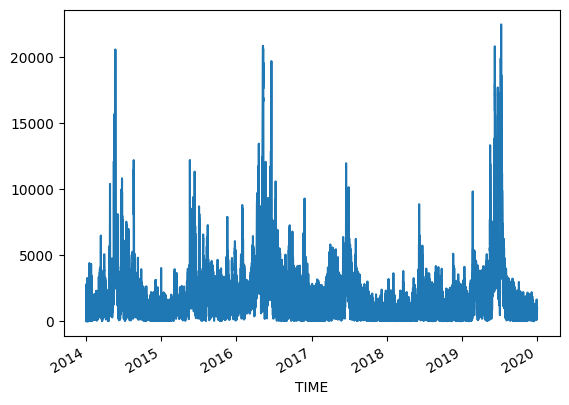

In [31]:
train_label[["TIME", "V"]].set_index("TIME")["V"].plot()

<h4>雨量分析</h4>

In [32]:
train_rain_one = train_rain[(train_rain["SENID"] == 210254)]  # & (train_rain["year"] == 2015) & (train_rain["month"] == 9) & (train_rain["day"] == 26)]

In [33]:
senids = set(train_rain["SENID"].unique()).intersection(set(test_rain["SENID"].unique()))

<h3>特征工程</h3>

<h4>确实最佳lag</h4>

In [34]:
def best_lag(x: DataFrame, y: DataFrame, max_lag: int) -> int:
    """
    确定x和y的最佳lag\n
    """
    df = pd.merge(x[["TIME", "V"]], y[["TIME", "V"]], how="outer", on="TIME")
    df = df.set_index("TIME", drop=True)
    df = df.interpolate(method="time")
    df = df.reindex(pd.date_range(start=y["TIME"].min(), end=y["TIME"].max(), freq="H"))
    df = df.interpolate(method="time")
    corrs = []
    for i in range(0, max_lag + 1):
        df_new = df.copy()
        if i > 0:
            df_new["V_y"] = df_new["V_y"].diff(i).shift(-i)
        df_new = df_new.dropna()
        df_new = (df_new - df_new.mean()) / df_new.std()
        corrs.append(df_new.corr().loc["V_x", "V_y"])
    return range(0, max_lag + 1)[np.argmax(corrs)]

<h4>不同站点横向拼接</h4>

In [35]:
def feature_engineering(x: DataFrame, y: DataFrame, lags: Optional[Dict] = None) -> (DataFrame, Dict):
    """
    特征工程\n
    """
    results = []
    lag_results = dict()
    for senid, df in tqdm(x.groupby("SENID")):
        if senid not in senids:
            continue
        if lags is None:
            lag = best_lag(df, y, 48)
            lag_results[senid] = lag
        else:
            if senid not in lags.keys():
                continue
            else:
                lag = lags[senid]
        df = pd.merge(df, y[["TIME"]], how="outer", on="TIME").sort_values("TIME")
        df = df.set_index("TIME", drop=True)
        df = df.drop(columns=["NAME", "SENID", "MAXT", "MINT", "year", "month", "day", "hour", "minute", "second", "AVGV", "MAXV", "MINV", "S", "AVGS", "MAXS", "MINS", "SPAN"])
        df = df.interpolate(method="time")
        df = df.reindex(pd.date_range(start=y["TIME"].min(), end=y["TIME"].max(), freq="H"))
        df = df.interpolate(method="time")
        df = df.rename(columns={k: f"{k}_{senid}" for k in df.columns})
        if lag > 0:
            df.index = df.index.shift(freq=f"{lag}H")
        results.append(df)
    result = pd.concat(results, axis=1)
    result["year"] = result.index.year
    result["month"] = result.index.month
    result["day"] = result.index.day
    result["hour"] = result.index.hour
    result[["year", "month", "day", "hour"]] = result[["year", "month", "day", "hour"]].astype("category")
    return result, lag_results

In [36]:
train_rain_group_by_senid, lags_by_senid = feature_engineering(train_rain, train_label)
test_rain_group_by_senid, _ = feature_engineering(test_rain, test_label, lags_by_senid)

  0%|          | 0/109 [00:00<?, ?it/s]

C:\Users\DrZon\AppData\Local\Temp\ipykernel_11516\3345270922.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result["year"] = result.index.year
C:\Users\DrZon\AppData\Local\Temp\ipykernel_11516\3345270922.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result["month"] = result.index.month
C:\Users\DrZon\AppData\Local\Temp\ipykernel_11516\3345270922.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

  0%|          | 0/124 [00:00<?, ?it/s]

C:\Users\DrZon\AppData\Local\Temp\ipykernel_11516\3345270922.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result["year"] = result.index.year
C:\Users\DrZon\AppData\Local\Temp\ipykernel_11516\3345270922.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result["month"] = result.index.month
C:\Users\DrZon\AppData\Local\Temp\ipykernel_11516\3345270922.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

<h4>整理标签</h4>

In [37]:
train_label = train_label.set_index("TIME", drop=True)
test_label = test_label.set_index("TIME", drop=True)

<h4>合并标签和特征</h4>

In [38]:
train_data = pd.merge(train_rain_group_by_senid, train_label[["V"]], how="right", left_index=True, right_index=True)
test_data = pd.merge(test_rain_group_by_senid, test_label[["V"]], how="right", left_index=True, right_index=True)
test_data = test_data.reindex(columns=train_data.columns)

<h4>划分xy</h4>

In [39]:
def split_xy(df: DataFrame, na_values: str = "fill") -> (DataFrame, Series):
    """
    划分xy\n
    """
    x = df.copy()
    if "fill" == na_values:
        y = x.pop("V")   
        y = y.fillna(method="bfill").fillna(method="ffill").fillna(0)
        x[x.select_dtypes(exclude=['category']).columns] = x[x.select_dtypes(exclude=['category']).columns].fillna(0).astype(np.float32)
    elif "drop" == na_values:
        x = x.dropna(how="all", subset=[x for x in x.columns if x not in ["year", "month", "day", "hour", "V"]])
        y = x.pop("V")
        y = y.fillna(method="bfill").fillna(method="ffill").fillna(0)
        x[x.select_dtypes(exclude=['category']).columns] = x[x.select_dtypes(exclude=['category']).columns].astype(np.float32)
    else:
        raise ValueError(f"未知的参数na_values={na_values}")
    return x, y

In [40]:
train_x, train_y = split_xy(train_data, "drop")
test_x, test_y = split_xy(test_data, "fill")

<h3>训练模型</h3>

<h4>评测指标</h4>

In [41]:
def score(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return 1 / (1 + rmse)

<h4>lightgbm模型</h4>

In [42]:
params_lgb = {
    "num_boost_round": 1000,
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 127,
    'verbose': -1,
    'seed': 42,
    'n_jobs': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    "early_stopping_round": 100
}
model_lgb = []

<h4>xgboost模型</h4>

In [43]:
params_xgb = {
    "num_boost_round": 500,
    "learning_rate": 0.02,
    "booster": "gbtree",
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_leaves": 127,
    "verbosity": 1,
    "seed": 42,
    "nthread": -1,
    "colsample_bytree": 0.6,
    "subsample": 0.7,
    "early_stopping_rounds": 100
}
model_xgb = []

<h4>交叉验证</h4>

In [44]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

mse = 0
for fold, (train_index, val_index) in enumerate(kfold.split(train_x, train_y)):
    logging.info(f'############ fold: {fold} ###########')
    x_train, x_val, y_train, y_val = train_x.iloc[train_index], train_x.iloc[val_index], train_y.iloc[train_index], train_y.iloc[val_index]
    
    trainset = Dataset(x_train, y_train)
    valset = Dataset(x_val, y_val)
    model = lgb.train(params_lgb, trainset, valid_sets=[trainset, valset], categorical_feature="auto", callbacks=[lgb.log_evaluation(1000)])
    model.save_model("../models/lgb_%d.txt" % fold)
    model_lgb.append(model)
    lgb_pred = Series(model.predict(x_val, num_iteration=model.best_iteration), index=y_val.index).fillna(0)
    
    trainset = DMatrix(x_train, y_train, enable_categorical=True, nthread=-1)
    valset = DMatrix(x_val, y_val, enable_categorical=True, nthread=-1)
    model = xgb.train(params_xgb, trainset, evals=[(trainset, 'train'),(valset, 'eval')], num_boost_round=params_xgb["num_boost_round"], early_stopping_rounds=params_xgb["early_stopping_rounds"], verbose_eval=1000)
    model.save_model("../models/xgb_%d.json" % fold)
    model_xgb.append(model)
    xgb_pred = Series(model.predict(valset, iteration_range=(0, model.best_ntree_limit)), index=y_val.index).fillna(0)
    
    val_pred = (lgb_pred + xgb_pred) / 2
    mse += mean_squared_error(y_val.fillna(0), val_pred)
rmse = np.sqrt(mse / kfold.n_splits)
score = 1 / (1 + rmse)
logging.info(f"--------------本地分数 {score}--------------")

2025-03-10 14:43:53,200 : INFO : ############ fold: 0 ###########
C:\Program Files\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1000]	training's rmse: 359.193	valid_1's rmse: 648.503
[14:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-rmse:2758.83114	eval-rmse:2750.76159
[499]	train-rmse:709.54945	eval-rmse:865.08895


2025-03-10 14:44:21,601 : INFO : ############ fold: 1 ###########
C:\Program Files\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1000]	training's rmse: 358.533	valid_1's rmse: 633.084
[14:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-rmse:2749.83109	eval-rmse:2791.05286
[499]	train-rmse:716.66221	eval-rmse:858.58268


2025-03-10 14:44:50,529 : INFO : ############ fold: 2 ###########
C:\Program Files\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1000]	training's rmse: 359.304	valid_1's rmse: 647.816
[14:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-rmse:2753.97539	eval-rmse:2779.20575
[499]	train-rmse:716.96809	eval-rmse:867.05027


2025-03-10 14:45:20,236 : INFO : ############ fold: 3 ###########
C:\Program Files\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1000]	training's rmse: 359.371	valid_1's rmse: 652.162
[14:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-rmse:2769.63720	eval-rmse:2711.30852
[499]	train-rmse:711.01472	eval-rmse:848.82128


2025-03-10 14:45:50,571 : INFO : ############ fold: 4 ###########
C:\Program Files\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1000]	training's rmse: 359.848	valid_1's rmse: 637.996
[14:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-rmse:2757.16700	eval-rmse:2759.67479
[499]	train-rmse:714.87435	eval-rmse:852.53322


2025-03-10 14:46:21,425 : INFO : --------------本地分数 0.0013788980702075114--------------


<h3>测试</h3>

<h4>计算测试集标签</h4>

In [45]:
y_pred = 0
for i in range(kfold.n_splits):
    lgb_pred = model_lgb[i].predict(test_x, num_iteration=model.best_iteration)
    xgb_pred = model_xgb[i].predict(DMatrix(test_x, enable_categorical=True, nthread=-1), iteration_range=(0, model.best_ntree_limit))
    y_pred += (lgb_pred + xgb_pred) / 2
y_pred = y_pred / kfold.n_splits

In [46]:
y_pred.shape

(17544,)

In [47]:
y_pred[y_pred < 0] = 0
test_label["V"] = y_pred
test_label["V"].iloc[0:24] = train_label["V"].iloc[-24:]

C:\Users\DrZon\AppData\Local\Temp\ipykernel_11516\1153454413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_label["V"].iloc[0:24] = train_label["V"].iloc[-24:]


<h4>保存文件</h4>

In [48]:
test_label[["V"]].to_csv(f"../data/submit/submit_{datetime.now().strftime('%Y%m%d-%H%M%S')}.csv")

<h3>last epoch大法</h3>

In [65]:
train_data_2019 = train_data[train_data["year"] == 2019].copy()
train_data_2019

,V_210254,AVGV_210254,MAXV_210254,MINV_210254,S_210254,AVGS_210254,MAXS_210254,MINS_210254,SPAN_210254,V_210454,...,S_1610254,AVGS_1610254,MAXS_1610254,MINS_1610254,SPAN_1610254,year,month,day,hour,V
TIME,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,...,2.0,2.0,2.0,2.0,1.0,2019,1,1,0,964.838
2019-01-01 01:00:00,0.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,...,2.0,2.0,2.0,2.0,1.0,2019,1,1,1,2105.581
2019-01-01 02:00:00,0.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,...,2.0,2.0,2.0,2.0,1.0,2019,1,1,2,956.995
2019-01-01 03:00:00,0.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,...,2.0,2.0,2.0,2.0,1.0,2019,1,1,3,357.836
2019-01-01 04:00:00,0.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,...,2.0,2.0,2.0,2.0,1.0,2019,1,1,4,155.644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,...,2.0,2.0,2.0,2.0,1.0,2019,12,31,19,385.296
2019-12-31 20:00:00,0.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,...,2.0,2.0,2.0,2.0,1.0,2019,12,31,20,607.572
2019-12-31 21:00:00,0.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,...,2.0,2.0,2.0,2.0,1.0,2019,12,31,21,801.849


In [66]:
test_label_2020 = train_data_2019[["V"]].copy()
test_label_2020.index = test_label_2020.index + DateOffset(years=1)
test_label_2021 = train_data_2019[["V"]].copy()
test_label_2021.index = test_label_2021.index + DateOffset(years=2)
result = pd.concat([test_label_2020, test_label_2021], axis=0)
result

,V
TIME,
2020-01-01 00:00:00,964.838
2020-01-01 01:00:00,2105.581
2020-01-01 02:00:00,956.995
2020-01-01 03:00:00,357.836
2020-01-01 04:00:00,155.644
...,...
2021-12-31 19:00:00,385.296
2021-12-31 20:00:00,607.572
2021-12-31 21:00:00,801.849


In [67]:
result = result.reindex(test_label.index).fillna(method="bfill").fillna(method="ffill").fillna(0)
result.to_csv(f"../data/submit/submit_{datetime.now().strftime('%Y%m%d-%H%M%S')}.csv")
result

,V
TIME,
2020-01-01 00:00:00,964.838
2020-01-01 01:00:00,2105.581
2020-01-01 02:00:00,956.995
2020-01-01 03:00:00,357.836
2020-01-01 04:00:00,155.644
...,...
2021-12-31 19:00:00,385.296
2021-12-31 20:00:00,607.572
2021-12-31 21:00:00,801.849
